In [1]:
%load_ext autotime

In [2]:
import os

from matplotlib import cm
from matplotlib import pyplot as plt
plt.style.use('bmh')

import numpy as np
import pandas as pd

from tqdm import tqdm_notebook as tqdm

from piaa.utils import pipeline
from piaa.utils import helpers
from piaa.utils import plot
from piaa.utils.postgres import get_cursor

from pocs.utils.images import fits as fits_utils
from astropy.io import fits
from astropy.stats import sigma_clip

tess_cursor = get_cursor(port=5433, db_name='v6', db_user='postgres')

styles = plot.get_labelled_style_cycler(cmap='Paired')

time: 2.19 s


## Specify Target

Here we look up the target HD189733 by the 2MASS ID.

In [25]:
# picid = 435715608
# picid = 287933433
picid = 287511722
# picid = 393243342
# picid = 343362027 # Hot pixel?

time: 675 µs


In [3]:
twomass = '20004370+2242391'

picid = helpers.get_star_info(twomass_id=twomass, cursor=tess_cursor).id  # HD 189733
print(f'PICID: {picid}')

PICID: 256364928
time: 85.1 ms


#### Observation sources

We use the previously detected and filtered sources to examine our target. See the [Source-Detection](Source-Detection-And-Filtering.ipynb) for details.

In [26]:
base_dir = '/var/panoptes/images/fields/PAN012/358d0f/20180822T035809/'
source_filename = os.path.join(base_dir, f'point-sources-filtered.csv')

time: 730 µs


In [27]:
sources = pipeline.lookup_sources_for_observation(filename=source_filename)

target_table = sources.loc[sources.picid == picid]

time: 560 ms


In [28]:
target_table.head()

,picid,mag_auto,magerr_auto,x,y,xpeak_image,ypeak_image,ra,dec,background,...,flux_max,fwhm_image,flags,snr,tmag,vmag,catalog_sep_arcsec,exp_time,airmass,file
obs_time,,,,,,,,,,,,,,,,,,,,,
2018-08-22 04:02:02,287511722,12.7557,0.0408,440,2289,440.7822,2289.2012,297.284632,27.729771,3159.684,...,6949.298,6.93,0,26.608792,6.385,6.916,6.025346,34.9,1.119109,20180822T040202.fits
2018-08-22 04:07:23,287511722,12.7640,0.0408,441,2290,441.5138,2290.3525,297.284757,27.729696,3170.106,...,6598.825,7.04,0,26.596778,6.385,6.916,5.890256,34.9,1.109075,20180822T040723.fits
2018-08-22 04:09:11,287511722,12.7708,0.0416,441,2290,441.3439,2290.3872,297.284692,27.729735,3168.633,...,5721.857,7.74,0,26.082568,6.385,6.916,5.954953,34.9,1.105848,20180822T040911.fits
2018-08-22 04:10:58,287511722,12.7384,0.0400,441,2291,441.2085,2290.5393,297.284475,27.729834,3140.796,...,5285.808,8.08,0,27.174501,6.385,6.916,6.302142,34.9,1.102694,20180822T041058.fits
2018-08-22 04:12:46,287511722,12.8508,0.0423,440,2289,440.7712,2288.7964,297.284831,27.729803,3200.085,...,6629.829,6.60,0,25.694651,6.385,6.916,5.459392,34.9,1.099610,20180822T041246.fits


time: 33.1 ms


#### Time-binned 

In addition to our raw data we want to bin the data according to time for the various flux measurements. The default is a 20 minute time bin and the values are averaged over that bin. Note that binning on time means there can be an uneven number of frames per bin.

Binning the data over time will smooth the scatter that's seen due to the periodic error (see below).

In [29]:
bin_minutes = 20

binned_sources = sources.groupby('picid').resample(f'{bin_minutes}T', level='obs_time')

time: 2.38 ms


In [30]:
# Get the columns we want for time binning
binned_flux = binned_sources.apply({
    'mag_auto': np.mean,
    'magerr_auto': np.mean,
    'flux_best': np.mean,
    'fluxerr_best': np.mean,        
    'flux_aper': np.mean,
    'fluxerr_aper': np.mean,        
    'background': np.mean,
    'snr': np.mean,
    'airmass': np.mean
})

time: 3.65 s


In [31]:
target_bin = binned_flux.loc[picid]

time: 3.13 ms


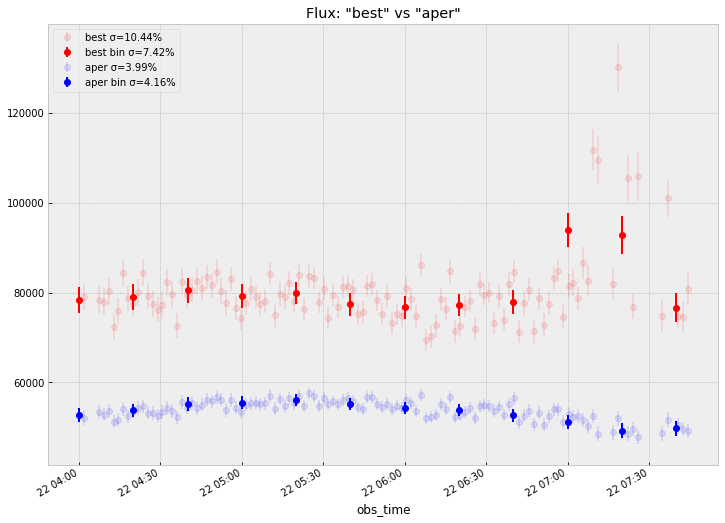

time: 702 ms


In [32]:
plt.figure(figsize=(12, 9))
std0 = target_bin.flux_best.std() / target_bin.flux_best.mean()
std1 = target_table.flux_best.std() / target_table.flux_best.mean()
target_table.flux_best.plot(yerr=target_table.fluxerr_best, ls='', marker='o', alpha=0.1, label=f'best σ={std1:.02%}', c='r')
target_bin.flux_best.plot(yerr=target_bin.fluxerr_best, ls='', marker='o', label=f'best bin σ={std0:.02%}', c='r')

std2 = target_bin.flux_aper.std() / target_bin.flux_aper.mean()
std3 = target_table.flux_aper.std() / target_table.flux_aper.mean()
target_table.flux_aper.plot(yerr=target_table.fluxerr_aper, ls='', marker='o', alpha=0.1,  label=f'aper σ={std3:.02%}', c='b')
target_bin.flux_aper.plot(yerr=target_bin.fluxerr_aper, ls='', marker='o', label=f'aper bin σ={std2:.02%}', c='b')

plt.title('Flux: "best" vs "aper"')
plt.legend()

#### Basic Aperture Photometry - sextractor

We can look at the basic aperture photometry using the instrumental magintude as it comes out of `sextractor`. A 6 pixel aperture is used and the local background is subtracted. Instrumental magnitudes are calculated with a zeropoint offset of 25.

Here we show the raw instrumental magnitudes as well as the magnitude averaged across a 20 minute time bin.

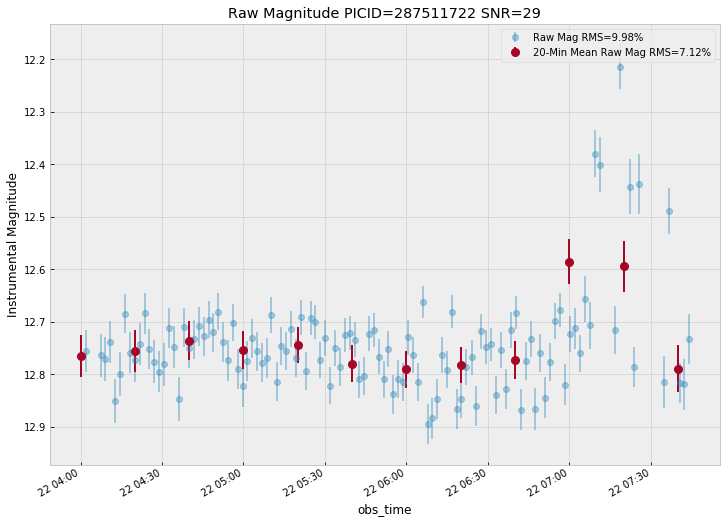

time: 667 ms


In [33]:
min_bin = 20
plt.figure(figsize=(12, 9))
target_table.mag_auto.plot(ls='', marker='o', yerr=target_table.magerr_auto, alpha=0.4, label=f'Raw Mag RMS={target_table.mag_auto.std():.02%}')

target_bin.mag_auto.plot(
                        ls='', marker='o', ms=8, 
                        yerr=target_bin.magerr_auto, 
                        label=f'{min_bin}-Min Mean Raw Mag RMS={target_bin.mag_auto.std():.02%}')

plt.title(f'Raw Magnitude PICID={picid} SNR={target_table.snr.mean():.0f}')
plt.ylabel('Instrumental Magnitude')
plt.gca().invert_yaxis()
plt.legend()
plt.show()

#### Differential photometry - sextractor

We can find some of the bright stars in the field and use them to correct for some of the major systematic effects that we are seeing in the light curve. We manually select three stars in the field and average them together and plot this versus our target instrumental magnitude.

Found 3 stars of similar magnitude


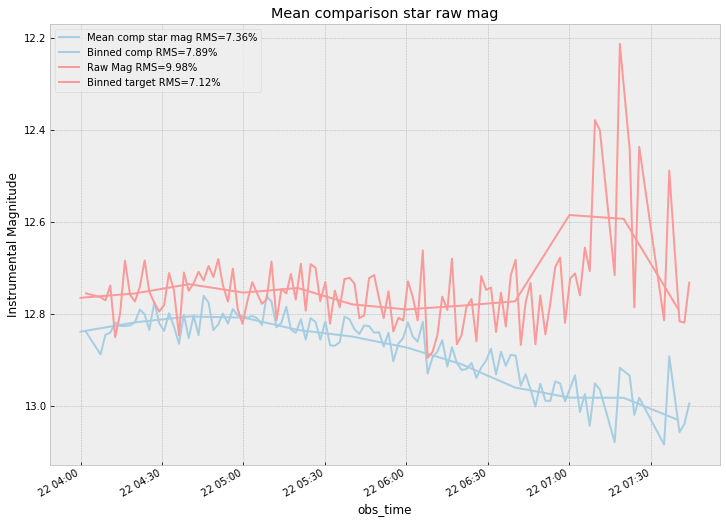

time: 669 ms


In [36]:
# Get the bright stars
bright_stars = sources.groupby('picid').snr.mean().sort_values(ascending=False).index.values[10:13]
# bright_stars = list(set(sources.loc[(sources.vmag == 7.67)].picid.values))
# bright_stars = list(set(sources.loc[np.logical_and(sources.vmag >= target_table.iloc[0].vmag - 0.1, sources.vmag <= target_table.iloc[0].vmag + 0.1)].picid))[0:5]
# bright_stars.remove(picid)
print(f'Found {len(bright_stars)} stars of similar magnitude')
bright_table = sources.loc[np.isin(sources.picid, bright_stars)]

# Plot the comp stars mean
plt.figure(figsize=(12, 9))
comp_star = bright_table.groupby('obs_time').mag_auto.mean()
# Sigma clip the comp star
# comp_star = comp_star.mask(sigma_clip(comp_star).mask)
binned_comp_star = binned_flux.loc[bright_stars].groupby('obs_time').mean()

comp_star.plot(label=f'Mean comp star mag RMS={comp_star.std():.02%}', **styles['comp_star'])
binned_comp_star.mag_auto.plot(label=f'Binned comp RMS={binned_comp_star.mag_auto.std():.02%}', **styles['comp_star'])

# Plot target
target_table.mag_auto.plot(label=f'Raw Mag RMS={target_table.mag_auto.std():.02%}', **styles[picid])
binned_flux.loc[picid].mag_auto.plot(label=f'Binned target RMS={binned_flux.loc[picid].mag_auto.std():.02%}', **styles[picid])

plt.gca().invert_yaxis()
plt.ylabel('Instrumental Magnitude')
plt.title('Mean comparison star raw mag')
plt.legend()

Now we can take the mean-combined comparison star and use it to normalize our target light curve. We do the same for the comparison stars, which we would expect to be flat.

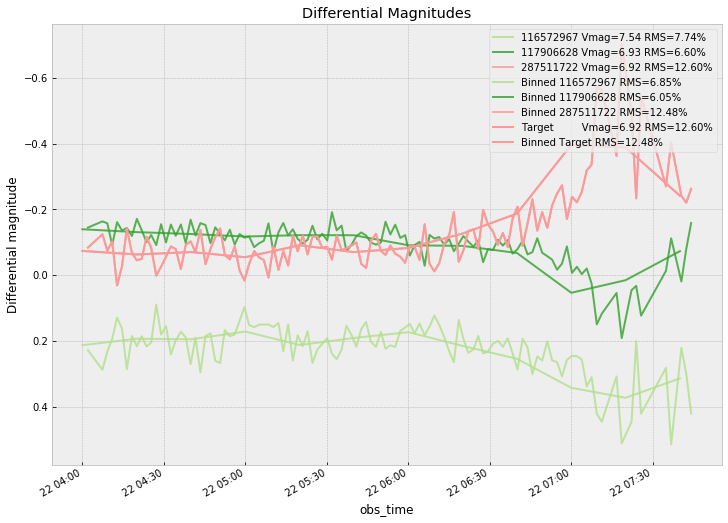

time: 789 ms


In [37]:
plt.figure(figsize=(12, 9))
for i, info in enumerate(bright_table.groupby('picid')):
    pid = info[0]
    row = info[1]
    c0 = (row.mag_auto - comp_star)
    c0.plot(label=f'{pid} Vmag={row.iloc[0].vmag:.02f} RMS={c0.std():.02%}', alpha=0.8, **styles[pid])
    
# Binned comparisons
for pid, row in binned_flux.loc[bright_stars].groupby('picid'):
    c1 = (row.loc[pid].mag_auto - binned_comp_star.mag_auto)
    c1.plot(label=f'Binned {pid} RMS={c1.std():.02%}', alpha=0.8, **styles[pid])

# Target
t0 = (target_table.mag_auto - comp_star)
t0.plot(label=f'Target         Vmag={target_table.iloc[0].vmag:.02f} RMS={t0.std():.02%}', **styles[picid])    
# Binned target
t1 = (target_bin.mag_auto - binned_comp_star.mag_auto)
t1.plot(label=f'Binned Target RMS={t1.std():.02%}', **styles[picid])    
    
plt.gca().invert_yaxis()

plt.ylabel('Differential magnitude')
plt.title('Differential Magnitudes')
plt.legend(loc=1)

We see that the comparison stars are corrected fairly well but our target still has some variability. In addition to the large dip (which we would hope to be a transit) the light curve has a lot more noise that almost appears periodic. This is the periodic motion of the star (due to the mechanics of the mount) on the RGB pixel pattern. At some points, for example, the centroid of the star's light might be more directly concentrated on a green pixel, at other times a red. Because these colors have different sensitivity responses we see either more or less signal. The data that is binned on time effectively smooths over these differences.

The brighter comparison stars still exhibit some of this pattern but it is less noticable because they are brighter and the light is already spread across more pixels to being with.

## Postage Stamp Cube (PSC)

We can use the positions from the `sources` table to extract a postage stamp for the target for each frame in the observation.

Unlike traditional photometry, which would try to place the centroid of the source directly in the center of the stamp, it is important for our purposes that each frame of the stamp have the same underlying pixel pattern. As a standard we enforce that all stamps have a red pixel in the bottom-left of the stamp provided that the origin (`(0,0)`) is in the bottom-left of the overall frame.

The star's centroid is placed within the center superpixel and a stamp size must have have an odd number of superpixels on each side of the center superpixel. The minimum stamp size is therefore 3x3 superpixels, or 6x6 regular pixels. The next size would be 5x5 superpixels or 10x10 pixels. Generally a stamp shold not need to be larger than 14x14 pixels. The size of the postage stamp will have an effect on the comparison stars that are selected by our algorithm.

A smaller 4-pixel aperture can later be pulled from the original stamp for any final photometric steps.

In [13]:
stamp_size = (6, 6)

In [ ]:
# Get the stamp slices for the observation
stamps = list()
for obstime, row in target_table.iterrows():
    s0 = helpers.get_stamp_slice(row.x, row.y, stamp_size=stamp_size)
    with fits.open(os.path.join(base_dir, row.file)) as hdul:
        d0 = hdul[0].data.astype(np.int) - int(row.background)
        stamps.append(d0[s0])
    
stamps = np.array(stamps)

In [ ]:
plt.plot(target_table.index, stamps.reshape(stamps.shape[0], -1).sum(1))
target_table.flux_auto.plot(ls='', marker='o', yerr=target_table.fluxerr_auto, alpha=0.4, label=f'Raw Mag RMS={target_table.mag_auto.std():.02%}')
plt.legend()

#### Color channel photometry

In [306]:
stamp_size = 4

color_sums = list()
for date_obs, row in tqdm(target_table.iterrows(), total=len(target_table)):
    
    # Get the data for the entire frame
    data = fits.getdata(os.path.join(base_dir, row.file)) 
    
    # Get the stamp for the target
    target_slice = helpers.get_stamp_slice(row.x, row.y, stamp_size=(stamp_size, stamp_size), ignore_superpixel=True)
    
    # Remove the background (from sextractor)
    stamp = data[target_slice] - row.background

    row_sums = [stamp.sum()]
    row_sums.extend(helpers.get_rgb_data(stamp).reshape(3, -1).sum(1))
    color_sums.append(row_sums)

color_sums = pd.DataFrame(color_sums, columns=['all', 'r', 'g', 'b'], index=target_table.index)

In [302]:
norm_colors = (color_sums / color_sums.mean())

In [303]:
norm_combined = (target_table.flux_auto / target_table.flux_auto.mean())

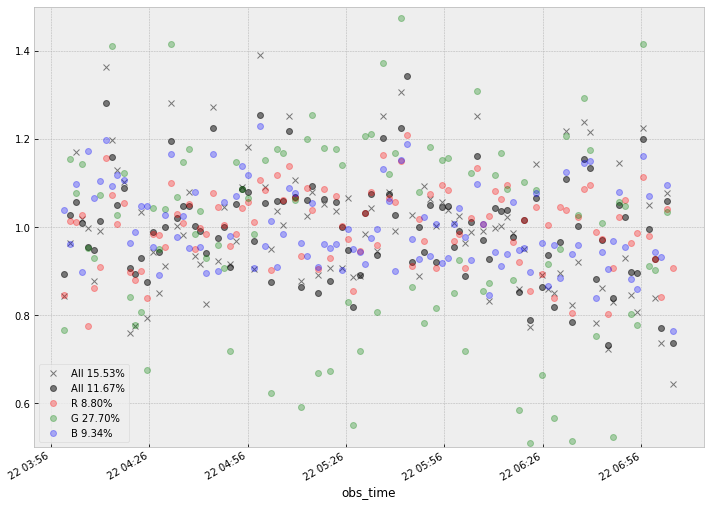

In [304]:
plt.figure(figsize=(12, 9))

norm_combined.plot(ls='', marker='x', color='k', alpha=0.5, label=f'All {norm_combined.std():.02%}')

norm_colors['all'].plot(ls='', marker='o', color='k', alpha=0.5, label='All {:.02%}'.format(norm_colors['all'].std()))
norm_colors.r.plot(ls='', marker='o', color='r', alpha=0.3, label=f'R {norm_colors.r.std():.02%}')
norm_colors.g.plot(ls='', marker='o', color='g', alpha=0.3, label=f'G {norm_colors.g.std():.02%}')
norm_colors.b.plot(ls='', marker='o', color='b', alpha=0.3, label=f'B {norm_colors.b.std():.02%}')

plt.ylim(0.5, 1.5)
plt.legend()

See [Find Similar Stars](PIAA-Find-Similar-Stars.ipynb)